# Step -2

### Step - 1 (Recap)
- The model is still large but working.
- We see some over-fitting.
- Accuracy needs improvement.

### Step - 2 (Action Items)
- Reduce parameters
- Training, Testing and Analyzing
- Making the network ready for further tuning

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary

## Data Transformations

We continue with existing transformation from Part -1 

Following transformations have been carried forward

1.   ToTensor conversion
2.   Normalize using mean and std of the entire MNST dataset - ((0.1307,), (0.3081,)) respectively.

In [ ]:
# Finding the mean and standard deviation values fro MNIST dataset
simple_transforms = transforms.Compose([
                                      transforms.ToTensor()
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Tensor Shape:', exp.train_data.size())
print(' - Min:', torch.min(exp_data))
print(' - Max:', torch.max(exp_data))
print(' - Mean:', torch.mean(exp_data))
print(' - Std:', torch.std(exp_data))
print(' - Var:', torch.var(exp_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Min: tensor(0.)
 - Max: tensor(1.)
 - Mean: tensor(0.1307)
 - Std: tensor(0.3081)
 - Var: tensor(0.0949)


# Building transformation rules for our dataset

In [ ]:
# Using the mean and standard deviation values to normalize the dataset.
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std for MNIST dataset
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])


# Dataset and Creating Train/Test Split with transformation rules.

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments 
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

Checking some of the statistics around our data.

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Min: tensor(-0.4242)
 - Max: tensor(2.8215)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


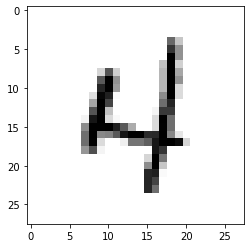

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - Min:', torch.min(train_data))
print(' - Max:', torch.max(train_data))
# The data has already been transformed using Mean and Standard deviation. 
# Going for a mean and standard deviation again would give us zeros and ones.
#print(' - Mean:', torch.mean(train_data)) 
#print(' - Std:', torch.std(train_data))
#print(' - Var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

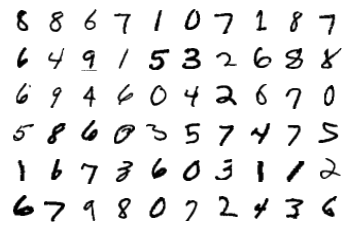

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
# Rebuilding the network again with a better readability and with fewer parameters.
# The out channels have been set in accordance with raising to the power 2 for a better GPU utilization.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Parameters of our new model as below

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"This network is being trained on {device}{('.' if use_cuda else ' because cuda is not available.')}")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

This network is being trained on cuda.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
            Conv2d-3           [-1, 12, 24, 24]           1,296
              ReLU-4           [-1, 12, 24, 24]               0
            Conv2d-5           [-1, 24, 22, 22]           2,592
              ReLU-6           [-1, 24, 22, 22]               0
         MaxPool2d-7           [-1, 24, 11, 11]               0
            Conv2d-8           [-1, 12, 11, 11]             288
              ReLU-9           [-1, 12, 11, 11]               0
           Conv2d-10             [-1, 12, 9, 9]           1,296
             ReLU-11             [-1, 12, 9, 9]               0
           Conv2d-12             [-1, 24, 7, 7]           2,592
             ReLU-13             [-1, 24, 7, 7]               0


# Observation

We still have less than 10k parameters. We will see how this model performs.

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Hence we are setting the graident to zero at the start of each loop so that the parameters update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=2.302665948867798 Batch_id=468 Accuracy=10.81: 100%|██████████| 469/469 [00:19<00:00, 23.94it/s]



Test set: Average loss: 2.3025, Accuracy: 1324/10000 (13.24%)

EPOCH: 1


Loss=2.302333116531372 Batch_id=468 Accuracy=14.35: 100%|██████████| 469/469 [00:19<00:00, 23.53it/s]



Test set: Average loss: 2.3021, Accuracy: 1275/10000 (12.75%)

EPOCH: 2


Loss=2.305213212966919 Batch_id=468 Accuracy=11.32: 100%|██████████| 469/469 [00:19<00:00, 23.62it/s]



Test set: Average loss: 2.2757, Accuracy: 1877/10000 (18.77%)

EPOCH: 3


Loss=0.2382485419511795 Batch_id=468 Accuracy=68.65: 100%|██████████| 469/469 [00:20<00:00, 23.44it/s]



Test set: Average loss: 0.3498, Accuracy: 8795/10000 (87.95%)

EPOCH: 4


Loss=0.2877388596534729 Batch_id=468 Accuracy=91.29: 100%|██████████| 469/469 [00:19<00:00, 23.46it/s]



Test set: Average loss: 0.2279, Accuracy: 9293/10000 (92.93%)

EPOCH: 5


Loss=0.11521464586257935 Batch_id=468 Accuracy=93.89: 100%|██████████| 469/469 [00:20<00:00, 23.41it/s]



Test set: Average loss: 0.1434, Accuracy: 9556/10000 (95.56%)

EPOCH: 6


Loss=0.09818068146705627 Batch_id=468 Accuracy=94.94: 100%|██████████| 469/469 [00:19<00:00, 23.63it/s]



Test set: Average loss: 0.1381, Accuracy: 9581/10000 (95.81%)

EPOCH: 7


Loss=0.07653839886188507 Batch_id=468 Accuracy=95.65: 100%|██████████| 469/469 [00:19<00:00, 23.54it/s]



Test set: Average loss: 0.1214, Accuracy: 9633/10000 (96.33%)

EPOCH: 8


Loss=0.2228543609380722 Batch_id=468 Accuracy=95.92: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s]



Test set: Average loss: 0.1114, Accuracy: 9683/10000 (96.83%)

EPOCH: 9


Loss=0.16625748574733734 Batch_id=468 Accuracy=96.27: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]



Test set: Average loss: 0.0967, Accuracy: 9704/10000 (97.04%)

EPOCH: 10


Loss=0.13645203411579132 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]



Test set: Average loss: 0.0868, Accuracy: 9738/10000 (97.38%)

EPOCH: 11


Loss=0.20345675945281982 Batch_id=468 Accuracy=96.68: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s]



Test set: Average loss: 0.0883, Accuracy: 9726/10000 (97.26%)

EPOCH: 12


Loss=0.09769215434789658 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:20<00:00, 23.45it/s]



Test set: Average loss: 0.0914, Accuracy: 9730/10000 (97.30%)

EPOCH: 13


Loss=0.05861401557922363 Batch_id=468 Accuracy=96.96: 100%|██████████| 469/469 [00:20<00:00, 23.44it/s]



Test set: Average loss: 0.0799, Accuracy: 9753/10000 (97.53%)

EPOCH: 14


Loss=0.09153047204017639 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]



Test set: Average loss: 0.0827, Accuracy: 9748/10000 (97.48%)



Text(0.5, 1.0, 'Test Accuracy')

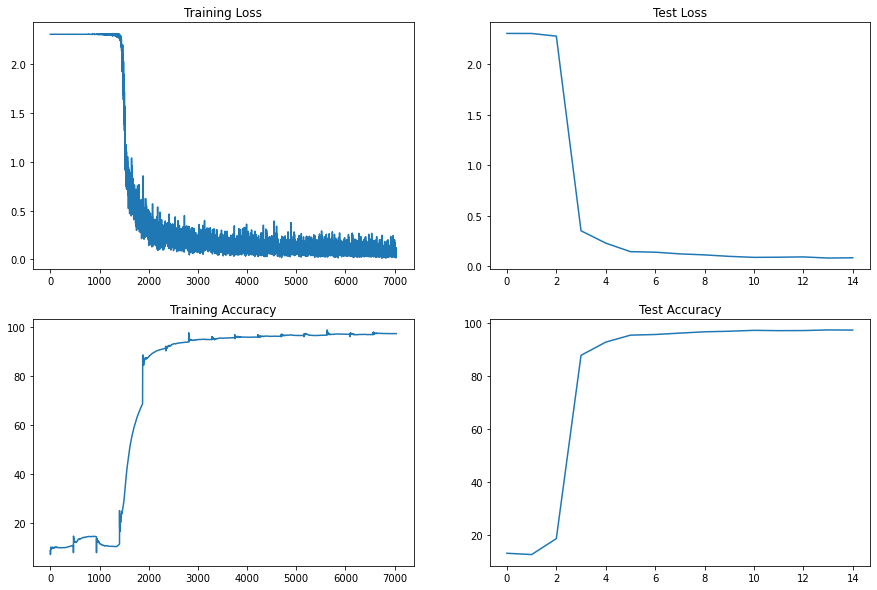

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### Inference:
- The model parameters are less than 10k. 
- Overfitting is eliminated. In fact we see some underfitting.
- Accuracy needs improvement. Accuracy has decreased as compared to Part -1.
- From the training loss curve we see that reducing the learning rate might improve the training accuracy.
